scipy available: True
output folder: plots_no_js


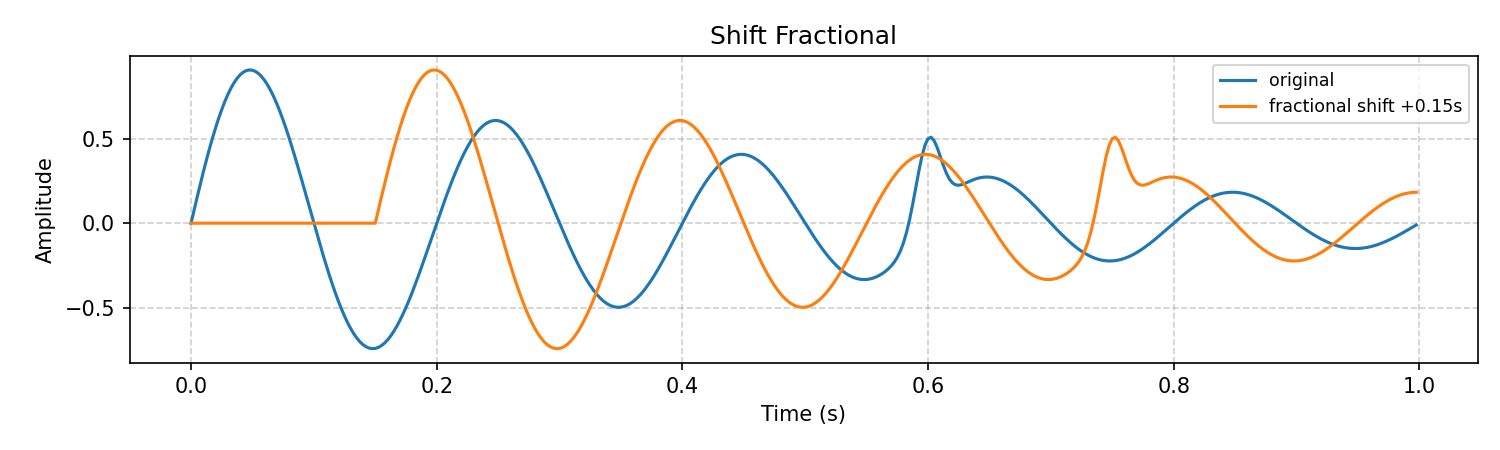

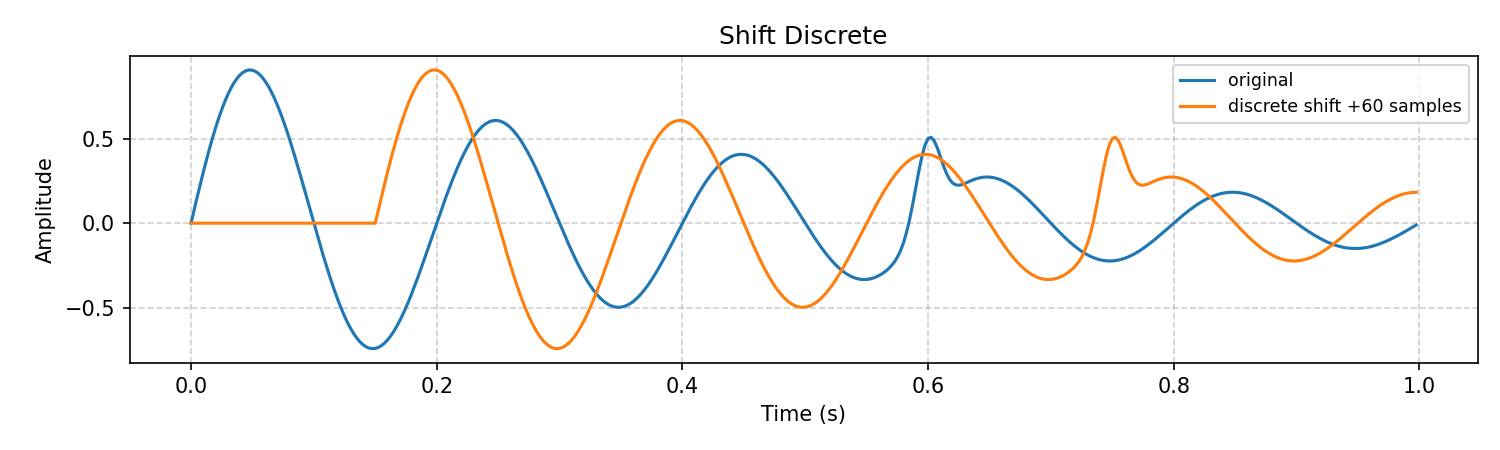

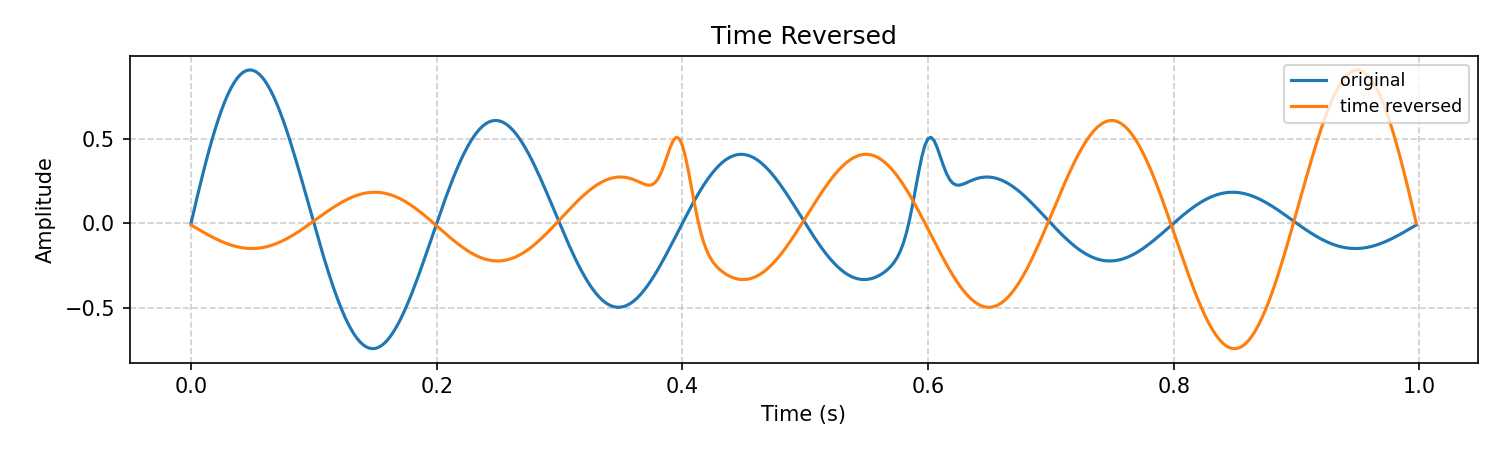

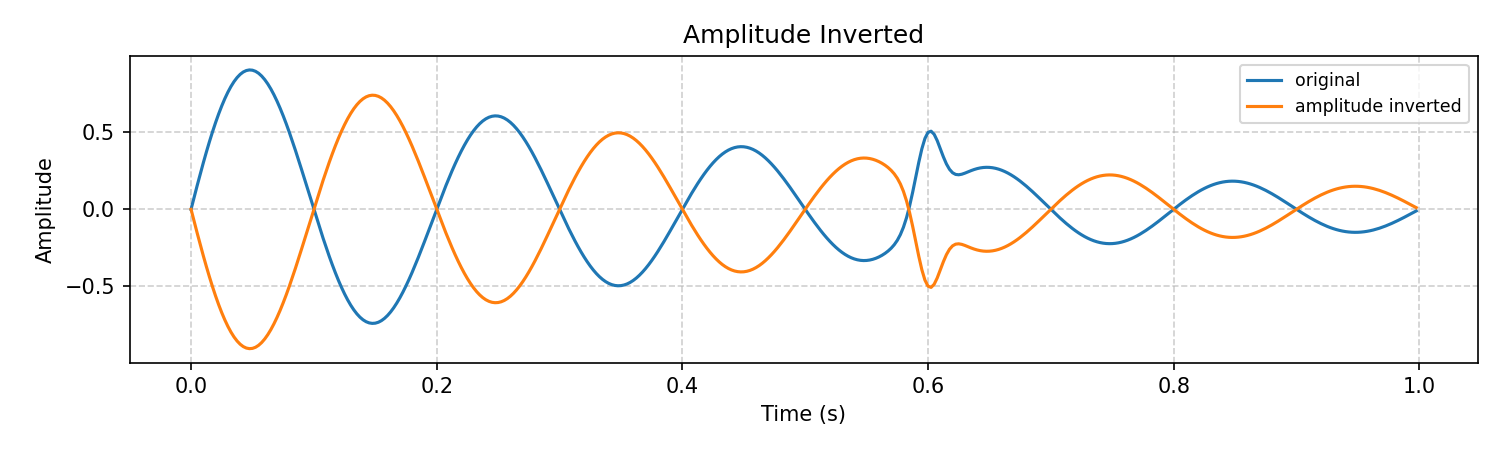

'plots_no_js\\amplitude_inverted.png'

In [1]:
# --- Imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# --- Check for scipy (optional) ---
try:
    from scipy.ndimage import shift as fractional_shift
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False

# --- Create output folder ---
OUT_DIR = "plots_no_js"
os.makedirs(OUT_DIR, exist_ok=True)

print("scipy available:", SCIPY_AVAILABLE)
print("output folder:", OUT_DIR)


# --- Signal setup ---
fs = 400                 # sampling frequency (Hz)
T = 1.0                  # duration (s)
t = np.linspace(0, T, int(fs * T), endpoint=False)
f = 5                    # tone frequency (Hz)

# Example signal: damped sine + small Gaussian spike
x = np.sin(2 * np.pi * f * t) * np.exp(-2 * t)
x += 0.5 * np.exp(-((t - 0.6) ** 2) / (2 * (0.01) ** 2))  # small spike for visibility


# --- Helper functions ---
def time_shift_discrete(x, samples):
    """Discrete circular shift using np.roll with zero-fill after roll."""
    y = np.roll(x, samples)
    if samples > 0:
        y[:samples] = 0
    elif samples < 0:
        y[samples:] = 0
    return y


def time_shift_fractional(x, shift_seconds, fs=fs):
    """Fractional shift using scipy.ndimage.shift if available, else interpolation."""
    samples_shift = shift_seconds * fs
    if SCIPY_AVAILABLE:
        y = fractional_shift(x, samples_shift, order=3, mode='constant', cval=0.0)
    else:
        orig_idx = np.arange(len(x))
        shifted_idx = orig_idx - samples_shift
        y = np.interp(shifted_idx, orig_idx, x, left=0.0, right=0.0)
    return y


def time_reverse(x):
    """Return time-reversed version of signal."""
    return x[::-1]


def amplitude_invert(x):
    """Return amplitude-inverted version of signal."""
    return -x


def plot_save_display(x_list, t, titles, filename_prefix="fig", out_dir=OUT_DIR, figsize=(10, 3)):
    """Plot, save, and display signals in Jupyter."""
    os.makedirs(out_dir, exist_ok=True)
    fname = os.path.join(out_dir, f"{filename_prefix}.png")

    plt.figure(figsize=figsize)
    for x, lbl in zip(x_list, titles):
        plt.plot(t, x, label=lbl)

    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(filename_prefix.replace("_", " ").title())
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()
    display(Image(filename=fname))
    return fname


# --- Transformations & Plots ---
shift_sec = 0.15
shift_samples = int(shift_sec * fs)

# Fractional (interpolated) shift
x_shift_frac = time_shift_fractional(x, shift_sec, fs=fs)

# Discrete (sample-based) shift
x_shift_disc = time_shift_discrete(x, shift_samples)

# Time reversal
x_reversed = time_reverse(x)

# Amplitude inversion
x_inverted = amplitude_invert(x)

# Plot all results
plot_save_display([x, x_shift_frac], t, ["original", f"fractional shift +{shift_sec}s"], filename_prefix="shift_fractional")
plot_save_display([x, x_shift_disc], t, ["original", f"discrete shift +{shift_samples} samples"], filename_prefix="shift_discrete")
plot_save_display([x, x_reversed], t, ["original", "time reversed"], filename_prefix="time_reversed")
plot_save_display([x, x_inverted], t, ["original", "amplitude inverted"], filename_prefix="amplitude_inverted")
